In [457]:
import pandas as pd
import numpy as np
import seaborn as sns
import pickle

from matplotlib import pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

from sklearn.metrics import roc_auc_score
%matplotlib inline

In [405]:
df = pd.read_csv('heart_statlog_cleveland_hungary_final.csv')

In [406]:
df = df.rename(columns=
                {'resting bp s': 'resting blood pressure',
                'target': 'heartdisease'}
)

In [407]:
df.columns = df.columns.str.lower().str.replace(' ','_')
df.fillna(0)
df.st_slope.value_counts()

st_slope
2    582
1    526
3     81
0      1
Name: count, dtype: int64

In [408]:
sex_values = {
    1: 'male',
    0: 'female',
}

df.sex = df.sex.map(sex_values)

chest_pain_type_values = {
    1: 'typical_angina',
    2: 'atypical_angina',
    3: 'non_anginal_pain',
    4: 'asymptomatic',
}

df.chest_pain_type = df.chest_pain_type.map(chest_pain_type_values)

fasting_blood_sugar_values = {
    1: 'true',
    0: 'false',
}

df.fasting_blood_sugar = df.fasting_blood_sugar.map(fasting_blood_sugar_values)

resting_ecg_values = {
    0: 'normal',
    1: 'st_t_wave_abnormal',
    2: 'lvh',
}

df.resting_ecg = df.resting_ecg.map(resting_ecg_values)

exercise_angina_values = {
    1: 'yes',
    0: 'no',
}

df.exercise_angina = df.exercise_angina.map(exercise_angina_values)

st_slope_values = {
    1: 'upsloping',
    2: 'flat',
    3: 'downsloping',
    0: 'flat',
}

df.st_slope = df.st_slope.map(st_slope_values)

In [409]:
df.head()

,age,sex,chest_pain_type,resting_blood_pressure,cholesterol,fasting_blood_sugar,resting_ecg,max_heart_rate,exercise_angina,oldpeak,st_slope,heartdisease
0,40,male,atypical_angina,140,289,false,normal,172,no,0.0,upsloping,0
1,49,female,non_anginal_pain,160,180,false,normal,156,no,1.0,flat,1
2,37,male,atypical_angina,130,283,false,st_t_wave_abnormal,98,no,0.0,upsloping,0
3,48,female,asymptomatic,138,214,false,normal,108,yes,1.5,flat,1
4,54,male,non_anginal_pain,150,195,false,normal,122,no,0.0,upsloping,0


In [410]:
df.dtypes

age                         int64
sex                        object
chest_pain_type            object
resting_blood_pressure      int64
cholesterol                 int64
fasting_blood_sugar        object
resting_ecg                object
max_heart_rate              int64
exercise_angina            object
oldpeak                   float64
st_slope                   object
heartdisease                int64
dtype: object

In [411]:

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)
numerical_columns   = list(df.dtypes[df.dtypes == 'int64'].index)
numerical_columns.append('oldpeak')

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')

In [412]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=11)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=11)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.heartdisease.values
y_val = df_val.heartdisease.values
y_test = df_test.heartdisease.values

del df_train['heartdisease']
del df_val['heartdisease']
del df_test['heartdisease']

In [413]:
len(df), len(y_train),len(y_val), len(y_test)

(1190, 714, 238, 238)

In [414]:
global_heartdisease_rate = df_full_train.heartdisease.mean()

In [415]:
from IPython.display import display

In [416]:
numerical_columns.remove('heartdisease')

In [417]:
for c in categorical_columns:
    print(c)
    df_group = df_full_train.groupby(c).heartdisease.agg(['mean', 'count'])
    df_group['diff'] = df_group['mean']-global_heartdisease_rate
    df_group['risk'] = df_group['mean']/global_heartdisease_rate
    display(df_group)
    print()
    print()

sex


,mean,count,diff,risk
sex,,,,
female,0.245614,228,-0.280646,0.466716
male,0.614641,724,0.088380,1.167940




chest_pain_type


,mean,count,diff,risk
chest_pain_type,,,,
asymptomatic,0.777778,504,0.251517,1.477933
atypical_angina,0.142857,168,-0.383403,0.271457
non_anginal_pain,0.293333,225,-0.232927,0.557392
typical_angina,0.345455,55,-0.180806,0.656433




fasting_blood_sugar


,mean,count,diff,risk
fasting_blood_sugar,,,,
false,0.466398,744,-0.059863,0.886249
true,0.740385,208,0.214124,1.406879




resting_ecg


,mean,count,diff,risk
resting_ecg,,,,
lvh,0.543396,265,0.017136,1.032561
normal,0.482569,545,-0.043692,0.916977
st_t_wave_abnormal,0.661972,142,0.135711,1.257879




exercise_angina


,mean,count,diff,risk
exercise_angina,,,,
no,0.331606,579,-0.194654,0.630118
yes,0.828418,373,0.302158,1.574160




st_slope


,mean,count,diff,risk
st_slope,,,,
downsloping,0.693548,62,0.167288,1.317880
flat,0.786164,477,0.259903,1.493868
upsloping,0.200969,413,-0.325292,0.381880


In [418]:
from sklearn.metrics import mutual_info_score

def mutual_info_heartdisease_score(series):
    return mutual_info_score(series, df_full_train.heartdisease)

mi = df_full_train[categorical_columns].apply(mutual_info_heartdisease_score)
mi.sort_values(ascending=False)

st_slope               0.173924
chest_pain_type        0.158707
exercise_angina        0.125777
sex                    0.051284
fasting_blood_sugar    0.026712
resting_ecg            0.007987
dtype: float64

In [419]:
df_full_train[numerical_columns].corrwith(df_full_train.heartdisease)

age                       0.236061
resting_blood_pressure    0.119859
cholesterol              -0.203725
max_heart_rate           -0.404725
oldpeak                   0.391376
dtype: float64

In [420]:
train_dicts = df_train[categorical_columns + numerical_columns].to_dict(orient='records')
val_dicts = df_val[categorical_columns + numerical_columns].to_dict(orient='records')
test_dicts = df_test[categorical_columns + numerical_columns].to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dicts)
x_val = dv.transform(val_dicts)
x_test = dv.transform(test_dicts)


In [421]:
#LOGISTICREGRESSION

model_log = LogisticRegression(C=1, max_iter=1000)
model_log.fit(x_train, y_train)

y_pred_log = model_log.predict_proba(x_val)[:,1]
auc_log = roc_auc_score(y_val, y_pred_log)
auc_log

0.9382138043555366

In [422]:
#Testing DecisionTree

scores = []
for d in [4,5,6,7,10,15,20, None]:
    for s in [1,2,5,10,15 ,20,100,200,500]:
        dt = DecisionTreeClassifier(max_depth=d, min_samples_leaf=s)
        dt.fit(x_train, y_train)

        y_pred = dt.predict_proba(x_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)

        scores.append((d,s,auc))
        print('(%4s, %3d) --> %.3f' %(d, s, auc))

(   4,   1) --> 0.928
(   4,   2) --> 0.928
(   4,   5) --> 0.926
(   4,  10) --> 0.917
(   4,  15) --> 0.923
(   4,  20) --> 0.916
(   4, 100) --> 0.894
(   4, 200) --> 0.749
(   4, 500) --> 0.500
(   5,   1) --> 0.919
(   5,   2) --> 0.924
(   5,   5) --> 0.922
(   5,  10) --> 0.907
(   5,  15) --> 0.928
(   5,  20) --> 0.918
(   5, 100) --> 0.894
(   5, 200) --> 0.749
(   5, 500) --> 0.500
(   6,   1) --> 0.916
(   6,   2) --> 0.931
(   6,   5) --> 0.930
(   6,  10) --> 0.911
(   6,  15) --> 0.927
(   6,  20) --> 0.918
(   6, 100) --> 0.894
(   6, 200) --> 0.749
(   6, 500) --> 0.500
(   7,   1) --> 0.877
(   7,   2) --> 0.887
(   7,   5) --> 0.926
(   7,  10) --> 0.911
(   7,  15) --> 0.930
(   7,  20) --> 0.919
(   7, 100) --> 0.894
(   7, 200) --> 0.749
(   7, 500) --> 0.500
(  10,   1) --> 0.882
(  10,   2) --> 0.897
(  10,   5) --> 0.927
(  10,  10) --> 0.913
(  10,  15) --> 0.929
(  10,  20) --> 0.919
(  10, 100) --> 0.894
(  10, 200) --> 0.749
(  10, 500) --> 0.500
(  15,   1

<Axes: xlabel='None-max_depth', ylabel='min_samples_leaf'>

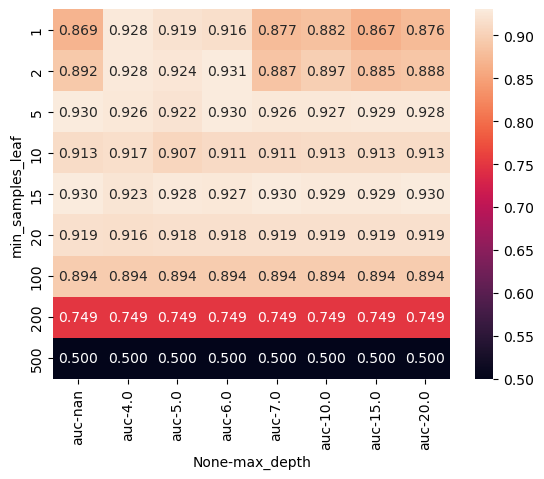

In [423]:
columns = ['max_depth', 'min_samples_leaf', 'auc']
df_scores = pd.DataFrame(scores, columns=columns)
df_scores_pivot = df_scores.pivot(index='min_samples_leaf', columns=['max_depth'], values=['auc'])
sns.heatmap(df_scores_pivot, annot=True, fmt='.3f')

In [424]:
max_depth = 6
min_samples_leaf = 15
dt = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf)
dt.fit(x_train, y_train)

y_pred = dt.predict_proba(x_val)[:,1]
auc_decisiontree = roc_auc_score(y_val, y_pred)
auc_decisiontree

0.9266510605093282

In [425]:
scores=[]

for d in [5,10,15]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=d, random_state=1)
        rf.fit(x_train, y_train)
    
        y_pred = rf.predict_proba(x_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((d, n, auc))

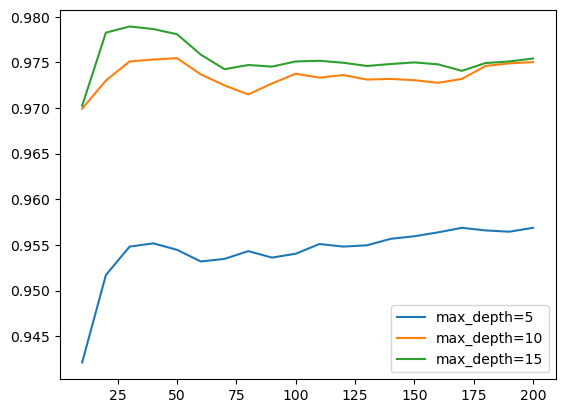

In [426]:
df_scores = pd.DataFrame(scores, columns = ['max_depth', 'n_estimators', 'auc'])
for d in [5,10,15]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.auc, label='max_depth=%s'%d)
plt.legend()

In [427]:
max_depth = 10
scores=[]

for s in [1,2,3,5,10,50]:
    for n in range(10,201,10):
        rf = RandomForestClassifier(n_estimators=n, max_depth=max_depth,min_samples_leaf = s, random_state=1)
        rf.fit(x_train, y_train)
    
        y_pred = rf.predict_proba(x_val)[:,1]
        auc = roc_auc_score(y_val, y_pred)
        scores.append((s, n, auc))

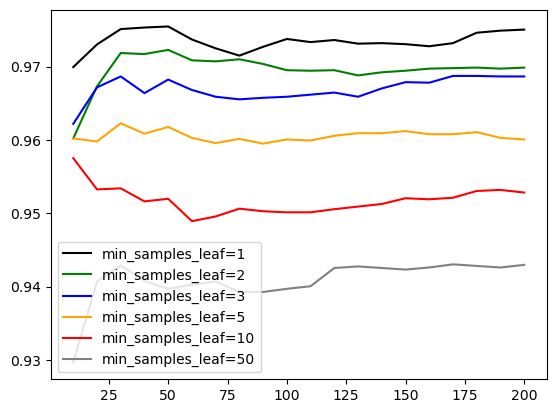

In [428]:
df_scores = pd.DataFrame(scores, columns = ['min_samples_leaf', 'n_estimators', 'auc'])
colors = ['black', 'green', 'blue', 'orange', 'red', 'grey']
values = [1, 2, 3, 5, 10, 50]

for s, col in zip(values, colors):
    df_subset = df_scores[df_scores.min_samples_leaf == s]
    plt.plot(df_subset.n_estimators, df_subset.auc, color=col, label='min_samples_leaf=%d'%s)
plt.legend()

In [429]:
max_depth = 10
min_samples_leaf = 1
n_estimators = 50
rf = RandomForestClassifier(n_estimators=n_estimators, max_depth=max_depth, min_samples_leaf = min_samples_leaf, random_state=1, n_jobs=-1 )
rf.fit(x_train, y_train)

y_pred = rf.predict_proba(x_val)[:,1]
auc_random_forest = roc_auc_score(y_val, y_pred)
auc_random_forest

0.9754557707313612

In [430]:
features = dv.get_feature_names_out()
feature_names = list(features)
dtrain = xgb.DMatrix(x_train, label=y_train, feature_names=feature_names)
dval = xgb.DMatrix(x_val, label=y_val, feature_names=feature_names)
dtest = xgb.DMatrix(x_test, label=y_test, feature_names=feature_names)

xgb_params= {
    'eta':0.3,
    'max_depth': 6,
    'min_child_weight':1,
    'objective': 'binary:logistic',
    'nthread':8,
    'seed':1,
    'verbosity':1
}

model = xgb.train(xgb_params, dtrain, num_boost_round=10)
y_pred = model.predict(dval)
roc_auc_score(y_val, y_pred)


0.9606653897992481

In [431]:
def parse_xgb_output(output):
    results = []

    for line in output.stdout.strip().split('\n'):
        num_iter, train_line, val_line = line.split('\t')

        it = int(num_iter.strip('[]'))
        train = float(train_line.split(':')[1])
        val = float(val_line.split(':')[1])

        results.append((it, train, val))
        
    columns = ['num_iter', 'train_auc', 'val_auc']
    df_results = pd.DataFrame(results, columns=columns)
    return df_results

In [432]:
watchlist = [(dtrain, 'train'), (dval, 'val')]
scores = {}

In [433]:
%%capture output

xgb_params = {
    'eta': 0.4, 
    'max_depth': 12,
    'min_child_weight': 1,
    
    'objective': 'binary:logistic',
    'eval_metric': 'auc',

    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

model = xgb.train(xgb_params, dtrain, num_boost_round=200,
                  verbose_eval=5,
                  evals=watchlist)

In [434]:
key = 'min_child_weight=%s' %(xgb_params['min_child_weight'])
scores[key] = parse_xgb_output(output)

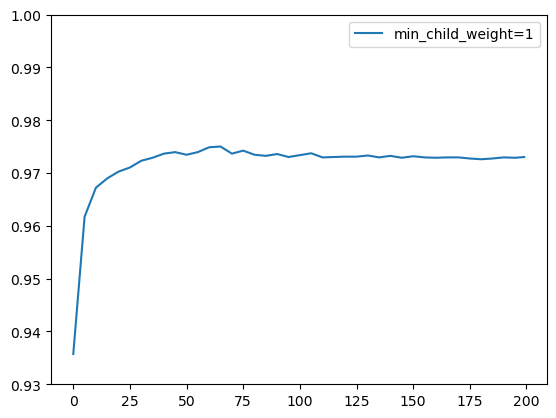

In [435]:
for min_child_weight, df_score in scores.items():
    plt.plot(df_score.num_iter, df_score.val_auc, label=min_child_weight)

plt.ylim(0.93,1)
plt.legend()

In [436]:
#after tuning eta=0.4,max_depth = 12, min_child_weight=1

In [437]:
xgb_params= {
    'eta':0.4,
    'max_depth': 12,
    'min_child_weight':1,
    'objective': 'binary:logistic',
    'nthread':8,
    'seed':1,
    'verbosity':1
}

model_xgb = xgb.train(xgb_params, dtrain, num_boost_round=66)
y_pred = model_xgb.predict(dval)
auc_xgb = roc_auc_score(y_val, y_pred)
auc_xgb

0.9750301482584948

In [438]:
y_pred_log = model_log.predict_proba(x_test)[:,1]
auc_log = roc_auc_score(y_test, y_pred_log)

y_pred_tree = dt.predict_proba(x_test)[:,1]
auc_decisiontree = roc_auc_score(y_test, y_pred_tree)

y_pred_forest = rf.predict_proba(x_test)[:,1]
auc_random_forest = roc_auc_score(y_test, y_pred_forest)

y_pred_xgb = model_xgb.predict(dtest)
auc_xgb = roc_auc_score(y_test, y_pred_xgb)

In [439]:
auc_log, auc_decisiontree, auc_random_forest, auc_xgb

(0.9034801136363637,
 0.8911931818181819,
 0.9404829545454545,
 0.9244318181818183)

In [448]:
predict = {
     'age': 56,
     'sex': 'male',
     'chest_pain_type': 'asymptomatic',
     'resting_blood_pressure': 150,
     'cholesterol': 230,
     'fasting_blood_sugar': 'true',
     'resting_ecg': 'st_t_wave_abnormal',
     'max_heart_rate': 124,
     'exercise_angina': 'yes',
     'oldpeak': 1.5,
     'st_slope': 'flat'
}
x_predict = dv.transform([predict])
x_predict.shape
rf.predict_proba(x_predict)

array([[0.00789773, 0.99210227]])

In [450]:
model_file = 'model_rf.bin'
with open(model_file, 'wb') as f_out:
    pickle.dump((dv, rf), f_out)

print(f'the model is save to {model_file}')

the model is save to model_rf.bin


NameError: name 'python' is not defined